In [1]:
from repath.preprocess.tissue_detection.blood_mucus import get_slides_annots
import repath.data.datasets.bloodmucus as bloodm

level = 7
dset = bloodm.blood_mucus()

#thumbz, annotz = get_slides_annots(dset, level)


In [2]:
from PIL import Image
import numpy as np

def show_np(arr_in):
    return Image.fromarray(np.array(arr_in, dtype=np.uint8))

#show_np(annotz[0]*50)


In [3]:
from repath.experiments.bloodmuc import *

train_classifier()


save:  /home/ubuntu/repath/experiments/bloodmucus


In [4]:
import json
from joblib import dump, load
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.ensemble import RandomForestClassifier

import repath.data.datasets.bloodmucus as bloodm
from repath.preprocess.patching import GridPatchFinder, SlidesIndex, CombinedIndex
from repath.preprocess.tissue_detection import TissueDetectorGreyScale, SizedClosingTransform, FillHolesTransform
from repath.preprocess.tissue_detection.blood_mucus import get_slides_annots, apply_tissue_detection, get_features_list, fit_segmenter_multi, predict_segmenter, get_features, pool_blood_mucus
from repath.utils.paths import project_root
from repath.utils.seeds import set_seed

"""
Global stuff
"""
experiment_name = "bloodmucus"
experiment_root = project_root() / "experiments" / experiment_name

global_seed = 123

In [5]:
# # set values
# set_seed(global_seed)
# level_label = 6
thumb_level = 7

# # read in slides and annotations for training
dset = bloodm.blood_mucus()
# thumbz, annotz = get_slides_annots(dset, level_label)
thumbz_out, annotz_out = get_slides_annots(dset, thumb_level)

# ## temp for debugging
# thumbz = thumbz[20:]
# annotz = annotz[20:]
# thumbz_out = thumbz_out[20:]
annotz_out = annotz_out[20:]

# # apply tissue detection
# morphology_transform1 = SizedClosingTransform(level_in=level_label)
# morphology_transform2 = FillHolesTransform(level_in=level_label)
# morphology_transforms = [morphology_transform1, morphology_transform2]
# tissue_detector = TissueDetectorGreyScale(grey_level=0.85, morph_transform = morphology_transforms)
# filtered_thumbz = apply_tissue_detection(thumbz, tissue_detector)

# # get features
# featz = get_features_list(filtered_thumbz)

# # load classifier
# clf = load(experiment_root / 'rforest.joblib')

# # settings
# patch_level = 0
# patch_size = 2**thumb_level
# stride = patch_size
# scale_factor = 2 ** (level_label - patch_level)
# kernel_size = int(patch_size / scale_factor)
# label_level_stride = int(stride / scale_factor)

# # set output directories
# labels_dir = experiment_root / 'labels'
# labels_dir.mkdir(parents=True, exist_ok=True)
# tissue_dir = experiment_root / 'tissue'
# tissue_dir.mkdir(parents=True, exist_ok=True)
# bloodm_dir = experiment_root / 'bloodm'
# bloodm_dir.mkdir(parents=True, exist_ok=True)
# annot_out_dir = experiment_root / 'annot_out'
# annot_out_dir.mkdir(parents=True, exist_ok=True)

In [6]:
# for idx, thumb in enumerate(thumbz):
#     features = get_features(thumb)
#     output = predict_segmenter(features, clf)
#     tissue_mask = tissue_detector(thumb)
#     filtered_output = np.where(np.logical_not(tissue_mask), 0, output)
#     output_labels = pool_blood_mucus(filtered_output, kernel_size, label_level_stride, 0)
#     # create image with just tissue 
#     thumb_out = thumbz_out[idx]
#     if thumb_out.shape[0:2] != output_labels.shape:
#         output_labels = output_labels[0:thumb_out.shape[0], 0:thumb_out.shape[1]]
#     tissue_output = np.where(np.expand_dims(output_labels, axis=-1) == 1, thumb_out, 255)
#     # create image with jsut blood mucus
#     bloodm_output = np.where(np.expand_dims(output_labels, axis=-1) == 2, thumb_out, 255)
#     # convert to pil images and write
#     filename = str(idx) + '.png'
#     labels_image = Image.fromarray(np.array(output_labels*100, dtype=np.uint8))
#     labels_image.save(labels_dir / filename)
#     annot_out_image = Image.fromarray(np.array(annotz_out[idx]*50, dtype=np.uint8))
#     annot_out_image.save(annot_out_dir / filename)
#     tissue_image = Image.fromarray(np.array(tissue_output, dtype=np.uint8))
#     tissue_image.save(tissue_dir / filename)
#     bloodm_image = Image.fromarray(np.array(bloodm_output, dtype=np.uint8))
#     bloodm_image.save(bloodm_dir / filename)
#     print(idx)

In [7]:
annot_out = annotz_out[0]
annot_out = np.expand_dims(annot_out, axis=-1)
annot_out_cl = np.dstack((annot_out, annot_out, annot_out))
tissue = np.array([255,255,255]).reshape((1,1,3))
blood = np.array([255,0,0]).reshape((1,1,3))
mucus = np.array([255,208,182]).reshape((1,1,3))
blmuc = np.array([186,85,211]).reshape((1,1,3))
annot_out_cl = np.where(annot_out == 1, tissue, annot_out_cl)
annot_out_cl = np.where(annot_out == 2, blood, annot_out_cl)
annot_out_cl = np.where(annot_out == 3, mucus, annot_out_cl)
annot_out_cl = np.where(annot_out == 4, blmuc, annot_out_cl)

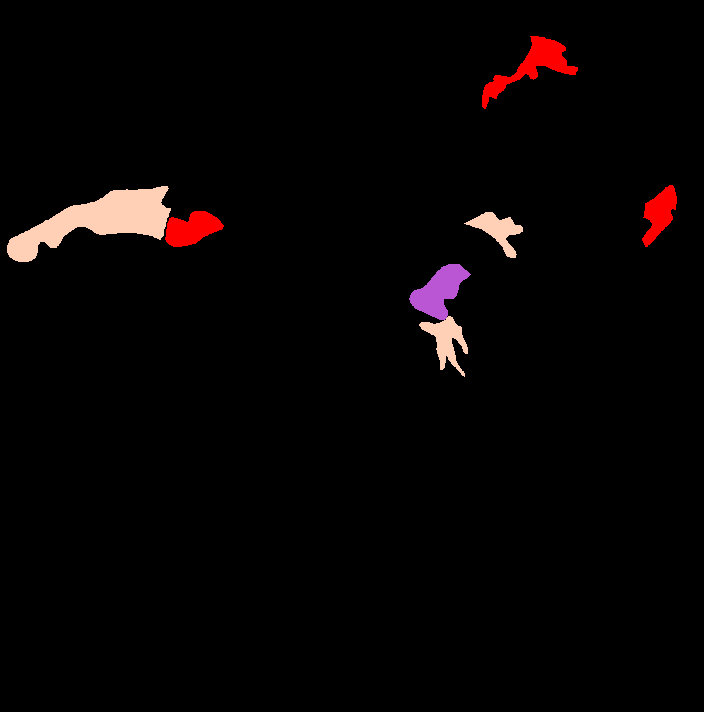

In [8]:
show_np(annot_out_cl)

In [9]:
# lab_im = Image.open(labels_dir / "0.png")
# tis_im = Image.open(tissue_dir / "0.png")
# blm_im = Image.open(bloodm_dir / "0.png")
# ann_im = Image.open(annot_out_dir / "0.png")

In [10]:
# def get_concat_h(im1, im2):
#     dst = Image.new('RGB', (im1.width + im2.width, im1.height))
#     dst.paste(im1, (0, 0))
#     dst.paste(im2, (im1.width, 0))
#     return dst

# def get_concat_v(im1, im2):
#     dst = Image.new('RGB', (im1.width, im1.height + im2.height))
#     dst.paste(im1, (0, 0))
#     dst.paste(im2, (0, im1.height))
#     return dst

# top_row = get_concat_h(lab_im, tis_im)#.save('data/dst/pillow_concat_h.jpg')
# low_row = get_concat_h(blm_im, ann_im)#.save('data/dst/pillow_concat_h.jpg')
# get_concat_v(top_row, low_row)#.save('data/dst/pillow_concat_v.jpg')


In [11]:
predict_images()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


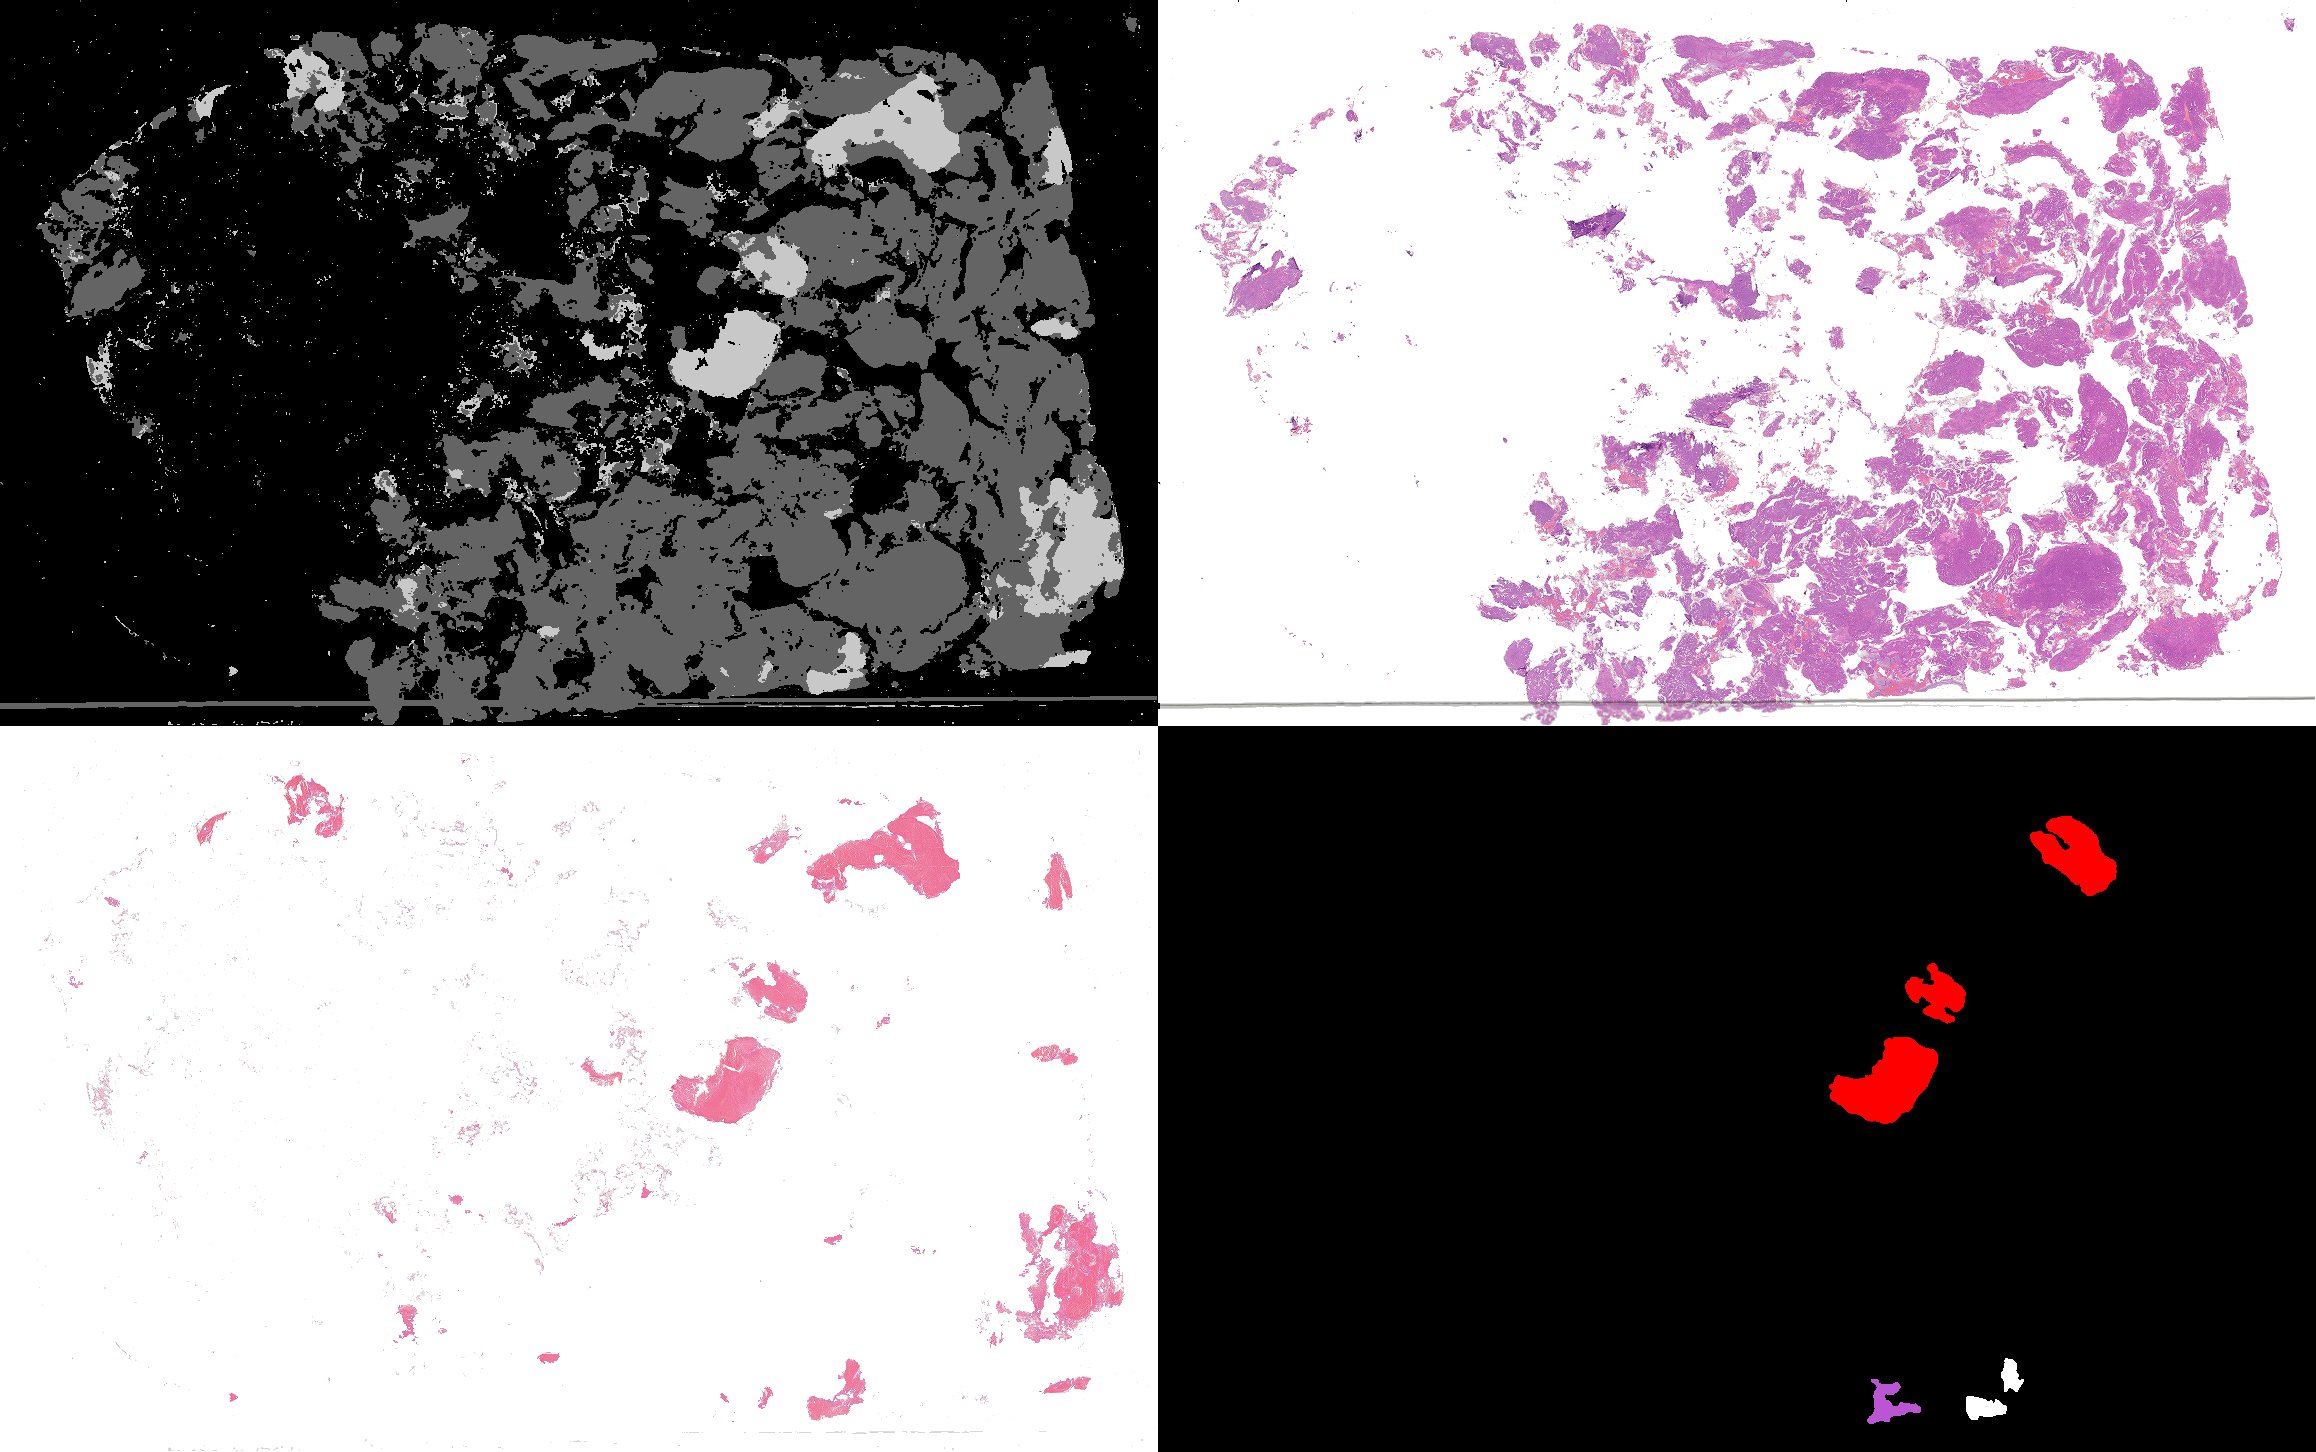

In [12]:
mosaic_dir = experiment_root / 'mosaic'
Image.open(mosaic_dir / "15.png")